##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/models/modify/model_maker) simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify flowers on a mobile device.

## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q tflite-model-maker

'sudo' is not recognized as an internal or external command,
operable program or batch file.


Import the required packages.

In [3]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

## Simple End-to-End Example

### Get the data path

Let's get some images to play with this simple end-to-end example. Hundreds of images is a good start for Model Maker while more data could achieve better accuracy.

In [4]:
image_path = tf.keras.utils.get_file(
      'flower_photos.tgz',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

228813984/228813984 [==============================] - 2s 0us/step


You could replace `image_path` with your own image folders. As for uploading data to colab, you could find the upload button in the left sidebar shown in the image below with the red rectangle. Just have a try to upload a zip file and unzip it. The root file path is the current path.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_image_classification.png" alt="Upload File" width="800" hspace="100">

If you prefer not to upload your images to the cloud, you could try to run the library locally following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) in GitHub.

### Run the example
The example just consists of 4 lines of code as shown below, each of which representing one step of the overall process.


Step 1.   Load input data specific to an on-device ML app. Split it into training data and testing data.

In [5]:
data = DataLoader.from_folder(image_path)
train_data, test_data = data.split(0.9)

INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


Step 2. Customize the TensorFlow model.

In [6]:
model = image_classifier.create(train_data)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


103/103 [==============================] - 6s 29ms/step - loss: 0.8827 - accuracy: 0.7637
Epoch 2/5
103/103 [==============================] - 3s 29ms/step - loss: 0.6577 - accuracy: 0.8890
Epoch 3/5
103/103 [==============================] - 3s 29ms/step - loss: 0.6248 - accuracy: 0.9157
Epoch 4/5
103/103 [==============================] - 3s 29ms/step - loss: 0.6028 - accuracy: 0.9266
Epoch 5/5
103/103 [==============================] - 3s 29ms/step - loss: 0.5901 - accuracy: 0.9326


Step 3. Evaluate the model.

In [7]:
loss, accuracy = model.evaluate(test_data)

12/12 [==============================] - 1s 36ms/step - loss: 0.6116 - accuracy: 0.9128


Step 4.  Export to TensorFlow Lite model.

Here, we export TensorFlow Lite model with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) which provides a standard for model descriptions. The label file is embedded in metadata. The default post-training quantization technique is full integer quantization for the image classification task.

You could download it in the left sidebar same as the uploading part for your own use.

In [8]:
model.export(export_dir='.')

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp5w3kj8xt/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp5w3kj8xt/assets
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-08-09 17:31:52.358366: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-09 17:31:52.358446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpucvfcam1/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpucvfcam1/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


After these simple 4 steps, we could further use TensorFlow Lite model file in on-device applications like in [image classification](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification) reference app.

## Detailed Process

Currently, we support several models such as  EfficientNet-Lite* models, MobileNetV2, ResNet50 as pre-trained models for image classification. But it is very flexible to add new pre-trained models to this library with just a few lines of code.


The following walks through this end-to-end example step by step to show more detail.

### Step 1: Load Input Data Specific to an On-device ML App

The flower dataset contains 3670 images belonging to 5 classes. Download the archive version of the dataset and untar it.

The dataset has the following directory structure:

<pre>
<b>flower_photos</b>
|__ <b>daisy</b>
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ <b>dandelion</b>
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
|__ <b>roses</b>
    |______ 102501987_3cdb8e5394_n.jpg
    |______ 14982802401_a3dfb22afb.jpg
    |______ ...
|__ <b>sunflowers</b>
    |______ 12471791574_bb1be83df4.jpg
    |______ 15122112402_cafa41934f.jpg
    |______ ...
|__ <b>tulips</b>
    |______ 13976522214_ccec508fe7.jpg
    |______ 14487943607_651e8062a1_m.jpg
    |______ ...
</pre>

In [9]:
image_path = tf.keras.utils.get_file(
      'flower_photos.tgz',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

Use `DataLoader` class to load data.

As for `from_folder()` method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.

In [10]:
data = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [11]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Show 25 image examples with labels.

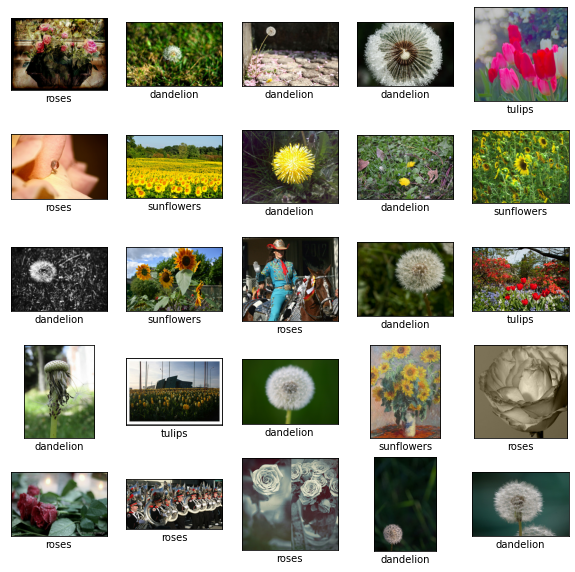

In [12]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


In [13]:
model = image_classifier.create(train_data, validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


91/91 [==============================] - 6s 42ms/step - loss: 0.8729 - accuracy: 0.7682 - val_loss: 0.6682 - val_accuracy: 0.8965
Epoch 2/5
91/91 [==============================] - 3s 36ms/step - loss: 0.6498 - accuracy: 0.8973 - val_loss: 0.6409 - val_accuracy: 0.9101
Epoch 3/5
91/91 [==============================] - 3s 37ms/step - loss: 0.6130 - accuracy: 0.9186 - val_loss: 0.6253 - val_accuracy: 0.9210
Epoch 4/5
91/91 [==============================] - 3s 37ms/step - loss: 0.5938 - accuracy: 0.9317 - val_loss: 0.6178 - val_accuracy: 0.9292
Epoch 5/5
91/91 [==============================] - 3s 37ms/step - loss: 0.5831 - accuracy: 0.9368 - val_loss: 0.6127 - val_accuracy: 0.9237


Have a look at the detailed model structure.

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [15]:
loss, accuracy = model.evaluate(test_data)

12/12 [==============================] - 1s 27ms/step - loss: 0.6775 - accuracy: 0.8638


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

12/12 [==============================] - 1s 25ms/step


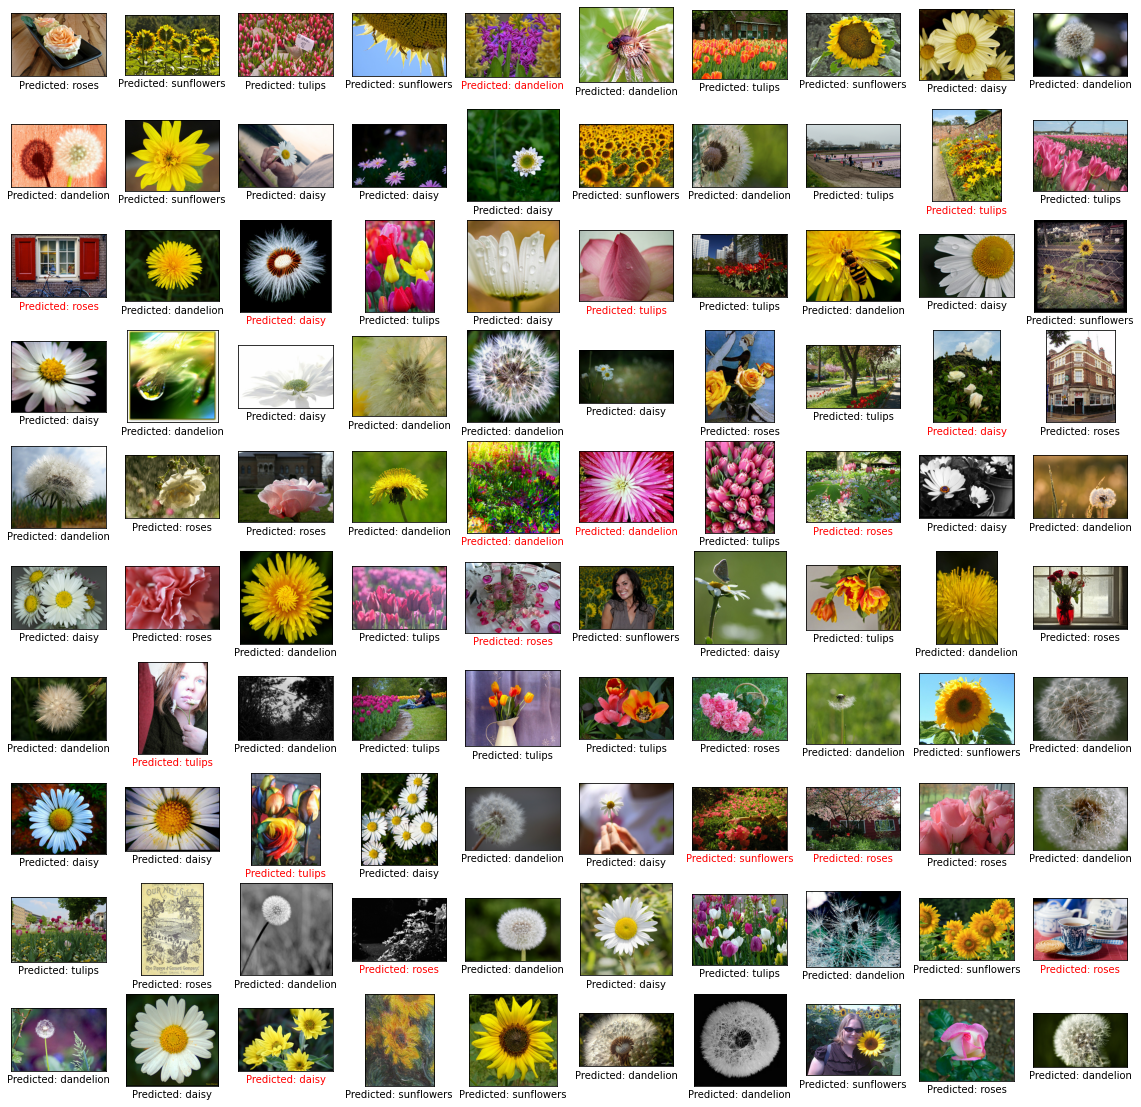

In [16]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 4: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/models/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full integer quantization for the image classification task.

In [17]:
model.export(export_dir='.')

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpfv90brbv/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpfv90brbv/assets
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-08-09 17:33:22.633536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-09 17:33:22.633611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmppioa76ji/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmppioa76ji/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


See the image classification [examples guide](https://www.tensorflow.org/lite/examples/image_classification/overview) for more details about how to integrate the TensorFlow Lite model into mobile apps.

This model can be integrated into an Android or an iOS app using the [ImageClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

The allowed export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`

By default, it just exports TensorFlow Lite model with metadata. You can also selectively export different files. For instance, exporting only the label file as follows:

In [18]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in ./labels.txt


INFO:tensorflow:Saving labels in ./labels.txt


You can also evaluate the tflite model with the `evaluate_tflite` method.

In [19]:
model.evaluate_tflite('model.tflite', test_data)

{'accuracy': 0.8637602179836512}

## Advanced Usage

The `create` function is the critical part of this library. It uses transfer learning with a pretrained model similar to the [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

The `create` function contains the following steps:

1.   Split the data into training, validation, testing data according to parameter `validation_ratio` and `test_ratio`. The default value of `validation_ratio` and `test_ratio` are `0.1` and `0.1`.
2.   Download a [Image Feature Vector](https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector) as the base model from TensorFlow Hub. The default pre-trained model is  EfficientNet-Lite0.
3.   Add a classifier head with a Dropout Layer with `dropout_rate` between head layer and pre-trained model. The default `dropout_rate` is the default `dropout_rate` value from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub.
4.   Preprocess the raw input data. Currently, preprocessing steps including normalizing the value of each image pixel to model input scale and resizing it to model input size.   EfficientNet-Lite0 have the input scale `[0, 1]` and the input image size `[224, 224, 3]`.
5.   Feed the data into the classifier model. By default, the training parameters such as training epochs, batch size, learning rate, momentum are the default values from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub. Only the classifier head is trained.


In this section, we describe several advanced topics, including switching to a different image classification model, changing the training hyperparameters etc.


## Customize Post-training quantization on the TensorFLow Lite model


[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.


Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

In [20]:
config = QuantizationConfig.for_float16()

Then we export the TensorFlow Lite model with such configuration.

In [21]:
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe4pzu436/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe4pzu436/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


2022-08-09 17:34:39.985359: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-09 17:34:39.985419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpw9mfb691/labels.txt


INFO:tensorflow:Saving labels in /tmpfs/tmp/tmpw9mfb691/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite


In Colab, you can download the model named `model_fp16.tflite` from the left sidebar, same as the uploading part mentioned above.

## Change the model


### Change to the model that's supported in this library.

This library supports  EfficientNet-Lite models, MobileNetV2, ResNet50 by now. [EfficientNet-Lite](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite) are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

We could switch model to MobileNetV2 by just setting parameter `model_spec` to the MobileNetV2 model specification in `create` method.

In [22]:
model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_2 (Hub  (None, 1280)             2257984   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


91/91 [==============================] - 8s 41ms/step - loss: 0.9229 - accuracy: 0.7596 - val_loss: 0.7215 - val_accuracy: 0.8583
Epoch 2/5
91/91 [==============================] - 3s 33ms/step - loss: 0.7008 - accuracy: 0.8808 - val_loss: 0.6964 - val_accuracy: 0.8774
Epoch 3/5
91/91 [==============================] - 3s 34ms/step - loss: 0.6574 - accuracy: 0.8932 - val_loss: 0.6772 - val_accuracy: 0.8747
Epoch 4/5
91/91 [==============================] - 3s 34ms/step - loss: 0.6329 - accuracy: 0.9148 - val_loss: 0.6752 - val_accuracy: 0.8692
Epoch 5/5
91/91 [==============================] - 3s 33ms/step - loss: 0.6127 - accuracy: 0.9190 - val_loss: 0.6895 - val_accuracy: 0.8610


Evaluate the newly retrained MobileNetV2 model to see the accuracy and loss in testing data.

In [23]:
loss, accuracy = model.evaluate(test_data)

12/12 [==============================] - 1s 25ms/step - loss: 0.7051 - accuracy: 0.8665


### Change to the model in TensorFlow Hub

Moreover, we could also switch to other new models that inputs an image and outputs a feature vector with TensorFlow Hub format.

As [Inception V3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1) model as an example, we could define `inception_v3_spec` which is an object of [image_classifier.ModelSpec](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/ModelSpec) and contains the specification of the Inception V3 model.

We need to specify the model name `name`, the url of the TensorFlow Hub model `uri`. Meanwhile, the default value of `input_image_shape` is `[224, 224]`. We need to change it to `[299, 299]` for Inception V3 model.

In [24]:
inception_v3_spec = image_classifier.ModelSpec(
    uri='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1')
inception_v3_spec.input_image_shape = [299, 299]

Then, by setting parameter `model_spec` to `inception_v3_spec` in `create` method, we could retrain the Inception V3 model.

The remaining steps are exactly same and we could get a customized InceptionV3 TensorFlow Lite model in the end.

### Change your own custom model

If we'd like to use the custom model that's not in TensorFlow Hub, we should create and export [ModelSpec](https://www.tensorflow.org/hub/api_docs/python/hub/ModuleSpec) in TensorFlow Hub.

Then start to define `ModelSpec` object like the process above.

## Change the training hyperparameters
We could also change the training hyperparameters like `epochs`, `dropout_rate` and `batch_size` that could affect the model accuracy. The model parameters you can adjust are:


*   `epochs`: more epochs could achieve better accuracy until it converges but training for too many epochs may lead to overfitting.
*   `dropout_rate`: The rate for dropout, avoid overfitting. None by default.
*   `batch_size`: number of samples to use in one training step.  None by default.
*   `validation_data`: Validation data. If None, skips validation process. None by default.
*   `train_whole_model`: If true, the Hub module is trained together with the classification layer on top. Otherwise, only train the top classification layer. None by default.
*   `learning_rate`: Base learning rate. None by default.
*   `momentum`: a Python float forwarded to the optimizer. Only used when
      `use_hub_library` is True. None by default.
*   `shuffle`: Boolean, whether the data should be shuffled. False by default.
*   `use_augmentation`: Boolean, use data augmentation for preprocessing. False by default.
*   `use_hub_library`: Boolean, use `make_image_classifier_lib` from tensorflow hub to retrain the model. This training pipeline could achieve better performance for complicated dataset with many categories. True by default. 
*   `warmup_steps`: Number of warmup steps for warmup schedule on learning rate. If None, the default warmup_steps is used which is the total training steps in two epochs. Only used when `use_hub_library` is False. None by default.
*   `model_dir`: Optional, the location of the model checkpoint files. Only used when `use_hub_library` is False. None by default.

Parameters which are None by default like `epochs` will get the concrete default parameters in [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/02ab9b7d3455e99e97abecf43c5d598a5528e20c/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L54) from TensorFlow Hub library or  [train_image_classifier_lib](https://github.com/tensorflow/examples/blob/f0260433d133fd3cea4a920d1e53ecda07163aee/tensorflow_examples/lite/model_maker/core/task/train_image_classifier_lib.py#L61).

For example, we could train with more epochs.


In [25]:
model = image_classifier.create(train_data, validation_data=validation_data, epochs=10)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_3 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/10
91/91 [==============================] - 6s 43ms/step - loss: 0.8824 - accuracy: 0.7534 - val_loss: 0.6930 - val_accuracy: 0.8719
Epoch 2/10
91/91 [==============================] - 3s 36ms/step - loss: 0.6553 - accuracy: 

Evaluate the newly retrained model with 10 training epochs.

In [26]:
loss, accuracy = model.evaluate(test_data)

12/12 [==============================] - 1s 27ms/step - loss: 0.6605 - accuracy: 0.8774


# Read more

You can read our [image classification](https://www.tensorflow.org/lite/examples/image_classification/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/models/modify/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ImageClassifier](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/raspberry_pi).

